In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import shutil
import sklearn as sk
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
from skimage import io
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
import tensorflow.keras.optimizers as optim
from tensorflow.keras import preprocessing as pp
from tensorflow.keras import callbacks as cb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from google.colab import drive

print(tf.__version__)
drive.mount('/content/drive', force_remount=True)

2.7.0
Mounted at /content/drive


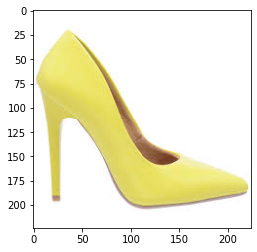

In [3]:
image = tf.keras.preprocessing.image.load_img(r'/content/drive/MyDrive/Projeto Integrador/Imagens/nao_recomendado/sapato_amarelo_salto_alto_1.png', target_size=(224,224))
plt.imshow(image)

In [4]:
batch_size = 32
img_size = 224
seed=42
root_dir = "/content/drive/MyDrive/Projeto Integrador/Imagens"
# os.listdir(root_dir) #Finds ".ipynb_checkpoints"
# shutil.rmtree(root_dir + "/.ipynb_checkpoints")

train_datagen = pp.image.ImageDataGenerator(rescale=1./255.,
                                            validation_split=0.2, # 0.33
                                            featurewise_std_normalization=False,
                                            rotation_range=20,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            horizontal_flip=True,
                                            vertical_flip=False, # testar depois
                                            brightness_range=[0.8,1.2]
                                            )

valid_datagen = pp.image.ImageDataGenerator(rescale=1./255, 
                                            validation_split=0.2, # 0.33
                                            featurewise_std_normalization=False)

valid_gen = valid_datagen.flow_from_directory(root_dir, subset='validation',\
                                              shuffle=True, seed=seed, 
                                              target_size=(img_size,img_size),\
                                              batch_size=batch_size, color_mode='rgb',
                                              class_mode='categorical')

Found 149 images belonging to 2 classes.


In [5]:
train_gen = train_datagen.flow_from_directory(root_dir, subset='training',\
                          shuffle=True, seed=seed, target_size=(img_size,img_size),\
                          batch_size=batch_size, color_mode='rgb',
                          class_mode='categorical')

Found 599 images belonging to 2 classes.


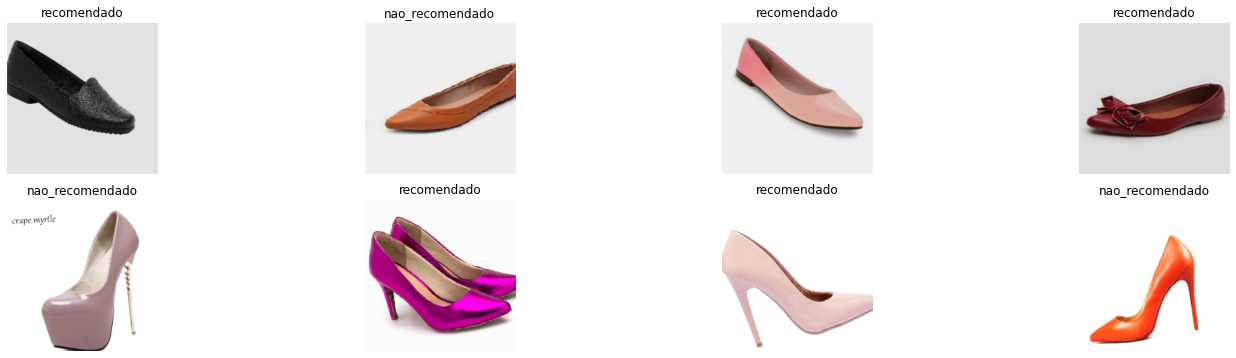

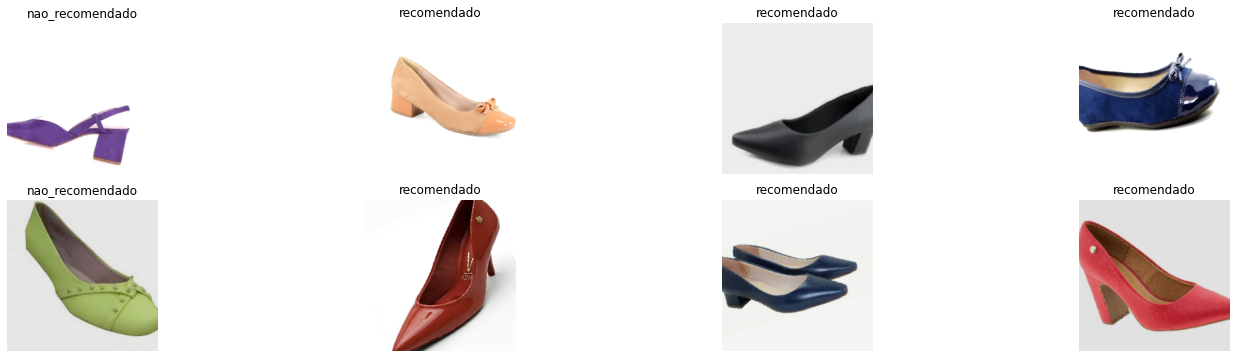

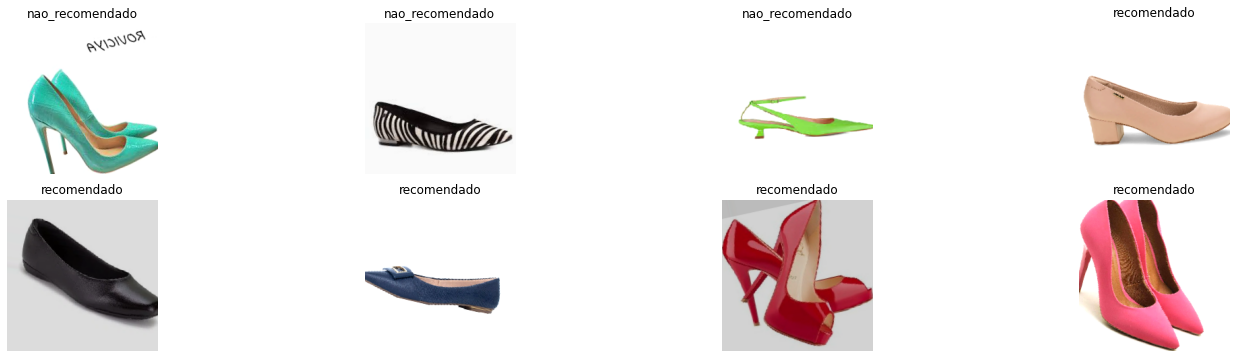

In [6]:
def decode(label): #Função para decodificar os labels 
    nomes = ['nao_recomendado',
             'recomendado']
    return nomes[np.argmax(label)]
  
def show_batch(images_, labels_):
    plt.figure(figsize=(20,10))
    for n in range(8):
        label = [x for x in labels_]
        image = [x for x in images_]
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image[n])
        plt.title(decode(label[n]))
        plt.axis('off')
        plt.tight_layout()
images_, labels_ = train_gen[2]
show_batch(images_, labels_)
images_, labels_ = train_gen[round(len(train_gen)/2)]
show_batch(images_, labels_)
images_, labels_ = train_gen[len(train_gen)-1]
show_batch(images_, labels_)

In [7]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=True,
                                    weights="imagenet",
                                    input_shape = (img_size,img_size,3)
                                  )

14548992/14536120 [==============================] - 1s 0us/step


In [8]:
model = tf.keras.Sequential()
model.add(mobilenet)
model.add(tf.keras.layers.Dense(1000,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) #
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) #
model.add(tf.keras.layers.Dense(2,activation='sigmoid')) # Número de categorias
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               256256    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                        

In [9]:
def train_model(lr, epochs, batch_size=32):
    
    opt = optim.Adam(learning_rate=lr, name='Adam')
    reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)
    e_stop=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=15, verbose=1, mode='auto',
                                restore_best_weights=True)

    model.compile(loss='categorical_crossentropy' ,
                  optimizer=opt, metrics=['AUC', 'CategoricalAccuracy'])
    
    with tf.device('/GPU:0'):
        history=model.fit(
                train_gen,
                steps_per_epoch= train_gen.samples // batch_size,
                epochs=epochs,
                validation_data= valid_gen,
                validation_steps= valid_gen.samples// batch_size, 
                callbacks=[reduce_lr,e_stop]
                )
    return history

history = train_model(lr=1e-4, epochs = 100, batch_size = batch_size)

Epoch 1/100
18/18 [==============================] - 150s 8s/step - loss: 0.6907 - auc: 0.5828 - categorical_accuracy: 0.5097 - val_loss: 0.6877 - val_auc: 0.5934 - val_categorical_accuracy: 0.5234 - lr: 1.0000e-04
Epoch 2/100
18/18 [==============================] - 17s 955ms/step - loss: 0.6706 - auc: 0.7103 - categorical_accuracy: 0.5185 - val_loss: 0.6843 - val_auc: 0.6022 - val_categorical_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
18/18 [==============================] - 17s 959ms/step - loss: 0.6051 - auc: 0.8589 - categorical_accuracy: 0.7725 - val_loss: 0.6734 - val_auc: 0.7104 - val_categorical_accuracy: 0.6953 - lr: 1.0000e-04
Epoch 4/100
18/18 [==============================] - 17s 936ms/step - loss: 0.5180 - auc: 0.9558 - categorical_accuracy: 0.9330 - val_loss: 0.6535 - val_auc: 0.8112 - val_categorical_accuracy: 0.7578 - lr: 1.0000e-04
Epoch 5/100
18/18 [==============================] - 17s 932ms/step - loss: 0.4338 - auc: 0.9824 - categorical_accuracy: 0.9771 - val_

In [ ]:
#model = tf.keras.models.load_model('drive/MyDrive/modelo_sapatos.h5')

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               256256    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                      

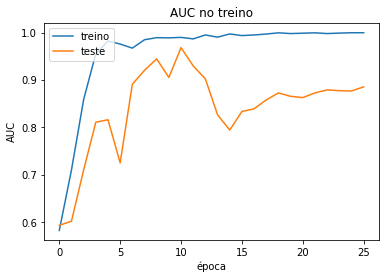

In [10]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC no treino')
plt.ylabel('AUC')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()


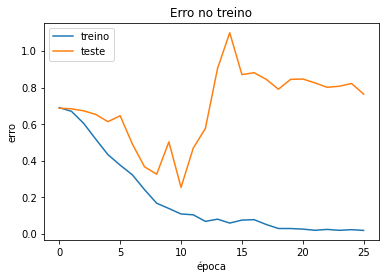

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro no treino')
plt.ylabel('erro')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

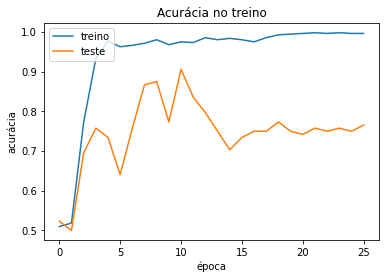

In [12]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Acurácia no treino')
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

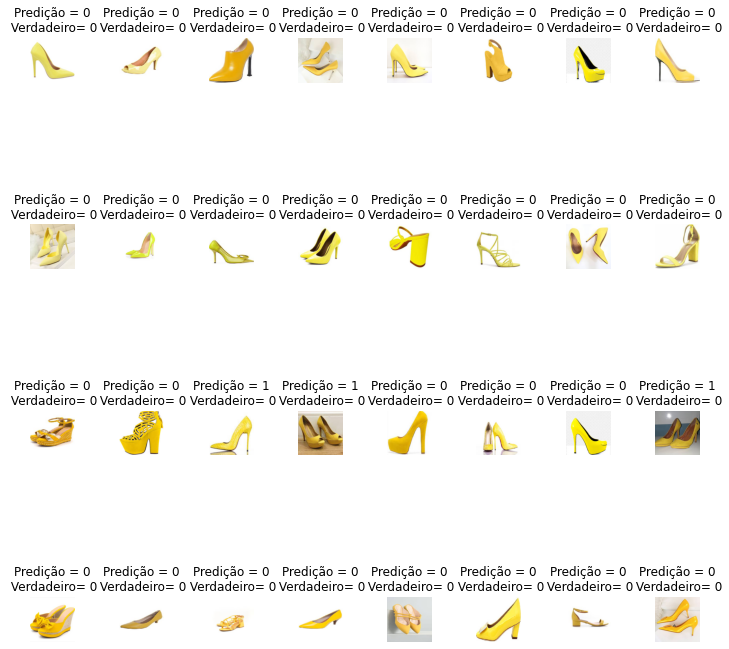

In [13]:
valid_gen.shuffle = False
valid_gen.index_array = None
L = 4
W = 8
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(valid_gen[0][0], batch_size=batch_size)
for i in np.arange(0,L*W):
    axes[i].imshow(valid_gen[0][0][i])
    axes[i].set_title('Predição = {}\n Verdadeiro= {}'.format(y_pred.argmax(axis=1)[i], valid_gen[0][1][i].argmax(axis=0)))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

In [14]:
y_pred0 = model.predict(valid_gen, batch_size)
y_pred1 = np.argmax(y_pred0, axis=1)

y_pred1.shape

print(valid_gen.classes)
print(y_pred1)

print(classification_report(valid_gen.classes, y_pred1,target_names=['nao_recomendado', 'recomendado']))
#print(classification_report(valid_gen.classes, y_pred1,target_names=['recomendado']))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
                 precision    recall  f1-score   support

nao_recomendado       0.96      0.85      0.90        75
    recomendado       0.87      0.96      0.91        74

       accuracy                           0.91       149
      macro avg       0.91      0.91      0.91       149
   weighted avg       0.91      0.91      0.91       149



In [15]:
accuracy_score(valid_gen.classes,y_pred1)

0.9060402684563759

[[64  3]
 [11 71]]


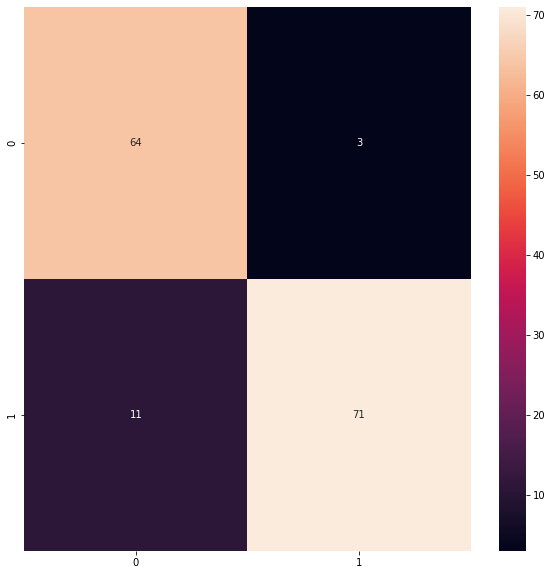

In [16]:
cm = confusion_matrix(y_pred1,valid_gen.classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)
print(cm)

In [17]:
model.save('drive/MyDrive/modelo_sapatos.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
